# Data Analyst Test Problem 1

Created in iPython Notebook

By **Guduguntla Vamshi** <gudugu@ncsu.edu>

for **WedPics - Data Scientist Test**

In [1]:
import pandasql as psql
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os
import sqlite3
from ggplot import *
%matplotlib inline
import MySQLdb
path_local = os.getcwd()

In [2]:
def mysql_connection():
    return MySQLdb.connect(host='localhost', port=3306,user='root', passwd='root', db='wedpics_test')

## SQL Implementation

In [3]:

"""
#-----------------------------THE FINAL QUERY BUILD--------------------------------------------------------------

# TABLE : tmp_output          - stores the aggregated time-frame and along with viral,
                                successful,active wedding numbers
# TABLE : tmp_overallweddings - stores the aggregated time-frame of OVERALL wedding numbers
"""

query1 = """

# var : DiffDate            - The number of days between wedding created and the wedding date 
# col : Active_weddings     - Aggregated number of active wedding sin the given time frame
# col : Successful_weddings - Aggregated number of successful weddings in the given time frame
# col : Viral_weddings      - Aggregated number of viral weddings in the given time frame

create table tmp_output as (

select q.DiffDate,sum(q.is_active_wedding) as Active_weddings,
sum(q.is_successful_wedding) as Successful_weddings,
sum(q.is_viral_wedding) as Viral_weddings
from (

select DATEDIFF(a.wedding_date,a.created_at) AS DiffDate,
b.wedding_id,

# ACTIVE WEDDING FLAG(1=yes,0=no)

# var : is_active_wedding - flag to indicate the whether active wedding or not ( specific to the wedding_id)

(select CASE WHEN count(*) >= 20 THEN 1 ELSE 0 END AS count 
FROM wedpics_test.media c
where c.wedding_id = a.id 
and is_flagged = 0
and is_wedding_profile = 0
and is_user_profile = 0
and publish_step = 2
) as is_active_wedding,

# VIRAL WEDDING FLAG(1=yes,0=no)

# - Defined as any member (admin or guest but not super admin) who creates a wedding after they 
# become part of the wedding
# - If a user was as Super admin before, and attended the any wedding later as guest/admin, 
# he/she would not included for the viral wedding contribution.
# - cnt - the number of weddings initiated by the user after attending the weddin as non super admin
# var : is_viral_wedding - flag to indicate the whether active wedding or not ( specific to the wedding_id)


(select case when sum((select count(*) from wedpics_test.users_weddings f
where f.is_admin = 'S'
and f.created_at > d.created_at 
and f.user_id = d.user_id
)) >= 1 then 1 else 0 end as cnt
from wedpics_test.users_weddings d
where (d.is_admin <> 'S' or d.is_admin is null)
and d.wedding_id = a.id
) as is_viral_wedding,


# SUCCESSFUL WEDDING FLAG(1=yes,0=no)
# var : is_successful_wedding - flag to indicate the whether SUCCESSFUL wedding or not ( specific to the wedding_id)

(select 
CASE 
WHEN 
count(*) >= 100 
and count(distinct date(d.created_at)) >= 3
and 
(select count(distinct e.user_id) from wedpics_test.users_weddings e where e.wedding_id = d.wedding_id)  >= 15
THEN 1 ELSE 0 END AS count 
FROM wedpics_test.media d
where  d.wedding_id = a.id
and d.is_flagged = 0
and d.is_wedding_profile = 0
and d.is_user_profile = 0
and d.publish_step = 2) as is_successful_wedding


from wedpics_test.weddings a
left join wedpics_test.users_weddings b 
on a.id = b.wedding_id
where 
date(a.wedding_date) between '2014-11-01' and '2014-12-31'
and a.payment = 1 
and a.is_deleted = 0
and b.is_admin = 'S'
ORDER BY is_viral_wedding desc
) as q
group by DiffDate
)
"""
query2 = """

# col : DiffDate            - The number of days between wedding created and the wedding date 
# col : num_weddings        -  Overall weddings in the given time frame

# we shall take the total wedding numbers in the period specified - Nov - Dec,2015

create table tmp_overallweddings as (
select DATEDIFF(a.wedding_date,a.created_at) AS DiffDate,count(*) as num_weddings
from wedpics_test.weddings a
left join wedpics_test.users_weddings b 
on a.id = b.wedding_id
where 
date(a.wedding_date) between '2014-11-01' and '2014-12-31'
and a.payment = 1 
and a.is_deleted = 0
and b.is_admin = 'S'
group by DiffDate
order by num_weddings desc
)
"""

query3 = """
#----------------------------------------THE FINAL RESULTS TABLE---------------------------------------

# col : Active_percent       -  Percent active weddings in the given time frame
# col : Successful_percent   -  Percent active weddings in the given time frame
# col : Viral_percent        -  Percent active weddings in the given time frame

select 
a.*,
round((a.Active_weddings/b.num_weddings) * 100,0) as Active_percent ,
round((a.Successful_weddings/b.num_weddings) * 100,0) as Successful_percent ,
round((a.Viral_weddings/b.num_weddings) * 100,0) as Viral_percent,
b.num_weddings

from tmp_output a 
inner join tmp_overallweddings b on a.DiffDate = b.DiffDate
"""

In [4]:
def execute_query():
    mysql_connection().query(query1)
    mysql_connection().query(query2)
    
execute_query()
df = pd.read_sql(query3, con=mysql_connection())   
df.to_csv(path_local+'output_sheet.csv')

### Snapshot of the output file

In [131]:
df.head()

,DiffDate,Active_weddings,Successful_weddings,Viral_weddings,Active_percent,Successful_percent,Viral_percent,num_weddings
0,0,370,109,48,30,9,4,1229
1,1,285,107,37,49,18,6,581
2,-1,172,41,14,36,9,3,476
3,2,228,91,27,51,20,6,446
4,3,230,90,20,53,21,5,438


### Question to answer

How far in advance should WedPics market its product to brides in order to achieve the most active, 
successful, and viral weddings?

### Looking at the number of weddings with the Time frame

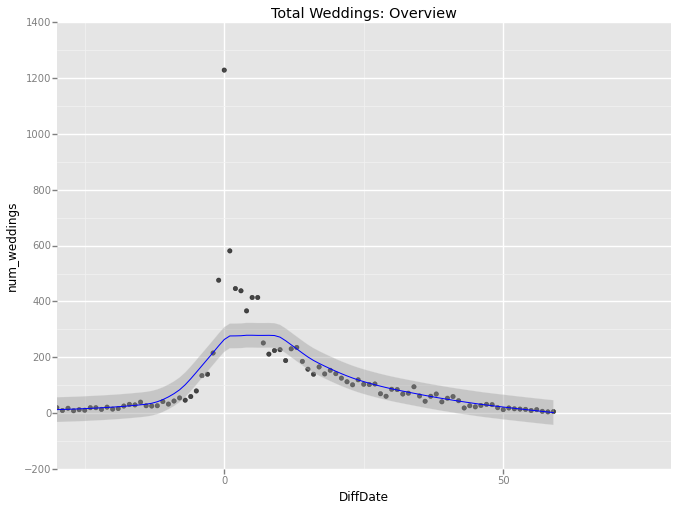

<ggplot: (291763697)>

In [13]:
ggplot(aes(x='DiffDate', y='num_weddings'), data=df) +\
    geom_point(color = 'black',alpha = 0.7) +\
    ggtitle("Total Weddings: Overview") + \
    stat_smooth(colour='blue', span=0.2) + scale_x_continuous(limits=(-30, 80))

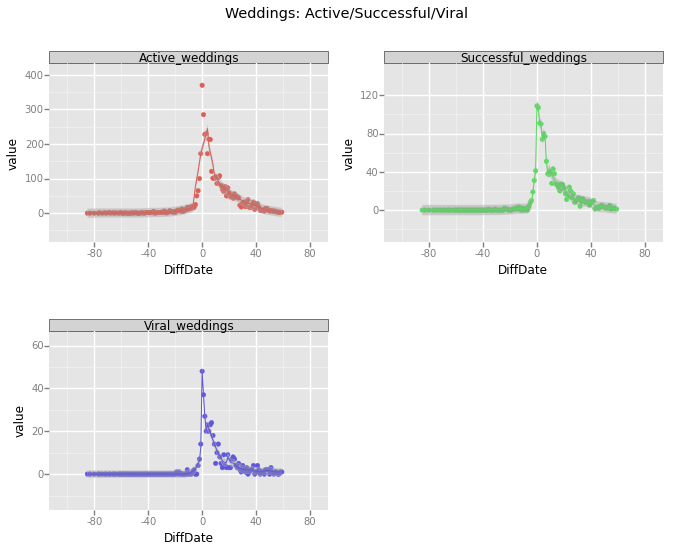

<ggplot: (294061573)>

In [77]:
df_melt= pd.melt(df[['DiffDate', 'Active_weddings', 'Successful_weddings', 'Viral_weddings']], id_vars=['DiffDate'])
ggplot(aes(x='DiffDate', y='value', color='variable'),data=df_melt) \
+ geom_point() + facet_wrap('variable') + stat_smooth(span=0.1) \
+ ggtitle("Weddings: Active/Successful/Viral") 

**Weddings: Active/Successful/Viral Summary:**

- There is a pattern for the active weddings on the time-frame
- We have notices the successful wedding are consistent between 8-15 days
- More of the viral weddings 20 days gap, there is a spike

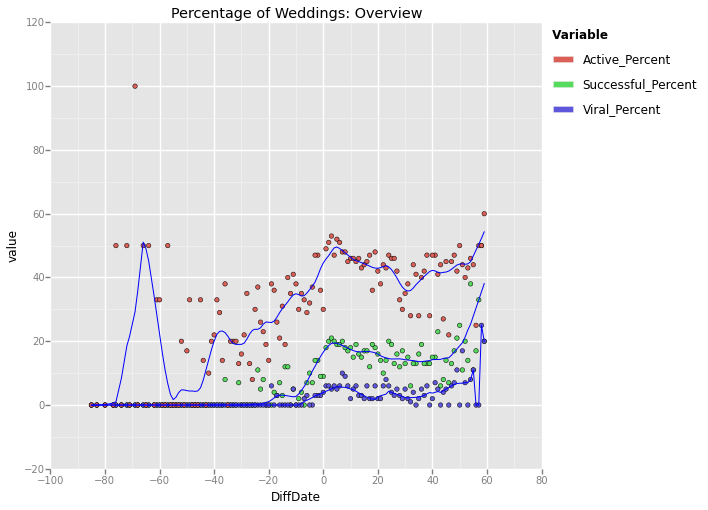

<ggplot: (292291081)>

In [88]:
df_melt= pd.melt(df[['DiffDate', 'Active_percent', 'Successful_percent', 'Viral_percent']], id_vars=['DiffDate'])
ggplot(df_melt,aes(x = 'DiffDate',y = 'value',fill='variable',ymin=0,ymax=100)) +\
   geom_point() + stat_smooth(colour='blue', span=0.09,alpha = 0.0) + ggtitle("Percentage of Weddings: Overview") 

## When are viral weddings more likely to happen?

- Taking a look at the top three quintiles

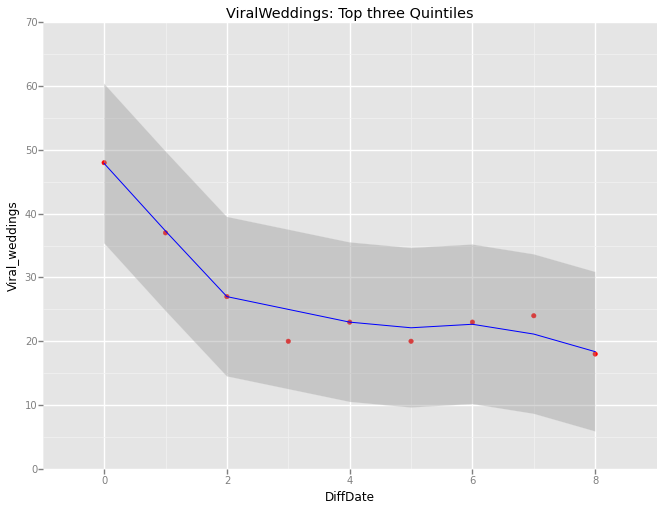

<ggplot: (291698853)>

In [130]:
df_viral = df[(df.Viral_weddings >= (np.mean(df.Viral_weddings) + 2. * np.std(df.Viral_weddings))) & (df.Viral_weddings <= np.max(df.Viral_weddings) )]
ggplot(df_viral,aes(x = 'DiffDate',y = 'Viral_weddings',)) +\
   geom_point(color ='red') + stat_smooth(colour='blue', span=0.50,alpha = 0.40) + ggtitle("ViralWeddings: Top three Quintiles") 

### Insights

- Weddings created at **25-40 days before** have high chance to be **Successful weddings** as they are distributed close 
  to active weddings. Therefore, this is the best time to push for generating more Successful weddings. 
- **Active weddings** are more than 40% likely to be featured when they are created 40 or more days in advance.
- **Viral weddings** are more likely to happen within a week of the wedding.


### Scope for further questions

- High volume of active weddings in the 0-10 day window(especially 0-5 half), shall we look 
  at **hours** rather than days ?  
- Likelihood estimate of a wedding going viral given it is a **Successful wedding** ? And how long does the wedding     take to **go viral once it is successful ?**
- Given that weddings created a couple of months in advance have good tendency to reach active and successful           states,what should be the actions taken to make them go **viral ?**